In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
#!py -m pip install stldecompose
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

pio.renderers.default='iframe'

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
# init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
import yfinance as yf  # for downloading stock data
from pandas.api.types import is_numeric_dtype
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

dataframe = yf.download("INTC", period="max")
#print ("shape = ", dataframe.shape)
#print(dataframe.head())

# we don't need Adj Close column
dataframe = dataframe.drop(columns=['Adj Close'])

# eliminate data before 2015
dataframe['Date'] = pd.to_datetime(dataframe.index)
dataframe = dataframe[(dataframe['Date'].dt.year >= 2015)].copy()
dataframe = dataframe.set_index('Date')

# In addition to the index column called 'Date', keep a new column called Date for future use
dataframe['Date'] = pd.to_datetime(dataframe.index)

print ("shape = ", dataframe.shape)
print(dataframe.head())

[*********************100%%**********************]  1 of 1 completed

shape =  (2412, 6)
                 Open       High        Low      Close    Volume       Date
Date                                                                       
2015-01-02  36.669998  37.160000  36.110001  36.360001  23605600 2015-01-02
2015-01-05  36.200001  36.450001  35.939999  35.950001  32785000 2015-01-05
2015-01-06  36.080002  36.230000  35.259998  35.279999  30847600 2015-01-06
2015-01-07  35.639999  36.070000  35.270000  36.020000  27725200 2015-01-07
2015-01-08  36.369999  37.000000  36.259998  36.689999  31765400 2015-01-08


In [3]:
#dataframe['Date'] = pd.to_datetime(dataframe['Date'], dayfirst=True)
#dataframe.index = pd.to_datetime(dataframe['Date'], dayfirst=True)
dataframe.sort_index(inplace=True)

In [4]:
####Prediction with Decision Trees

# Split input set (X) and output set (y)
X = dataframe.drop (columns=['Open'])
y = dataframe['Open']

In [5]:
#
# TEST 1 - Split Date into separate columns and test random times within the available range
#
# Split the data randomly into 80% Training and 20% Testing by random shuffling

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_dataframe, test_dataframe = train_test_split (dataframe, test_size=0.2, shuffle=True)

In [6]:
#Split Date object into separate features
def date_transform(data):
    dataframe = data.copy()
    
    dataframe['Hour'] = dataframe.index.hour
    dataframe['Dayofweek'] = dataframe.index.dayofweek
    dataframe['Dayofmonth'] = dataframe.index.day
    dataframe['Dayofyear'] = dataframe.index.dayofyear
    dataframe['weekofyear'] = dataframe.index.isocalendar().week
    dataframe['Month'] = dataframe.index.month
    dataframe['Quarter'] = dataframe.index.quarter
    dataframe['Year'] = dataframe.index.year
    
    X = dataframe.drop(['Date', 'Open'], axis=1)
    y = dataframe['Open']
    
    return X, y

In [7]:
X_train, y_train = date_transform(train_dataframe)
X_test, y_test = date_transform(test_dataframe)

In [8]:
from sklearn.tree import DecisionTreeRegressor
dtModel = DecisionTreeRegressor()
dtModel.fit(X_train, y_train)
dtModel.score (X_test, y_test)

0.9969978981591713

In [9]:
predictions = dtModel.predict(X_test)

In [10]:
# If you want to print the decision tree for visualizing in VS Code
# from sklearn import tree
# tree.export_graphviz(model, out_file='decisiontreeregressor_viztree.dot', feature_names=['Date'], class_names=sorted(y.unique()), label='all', rounded=True, filled=True)

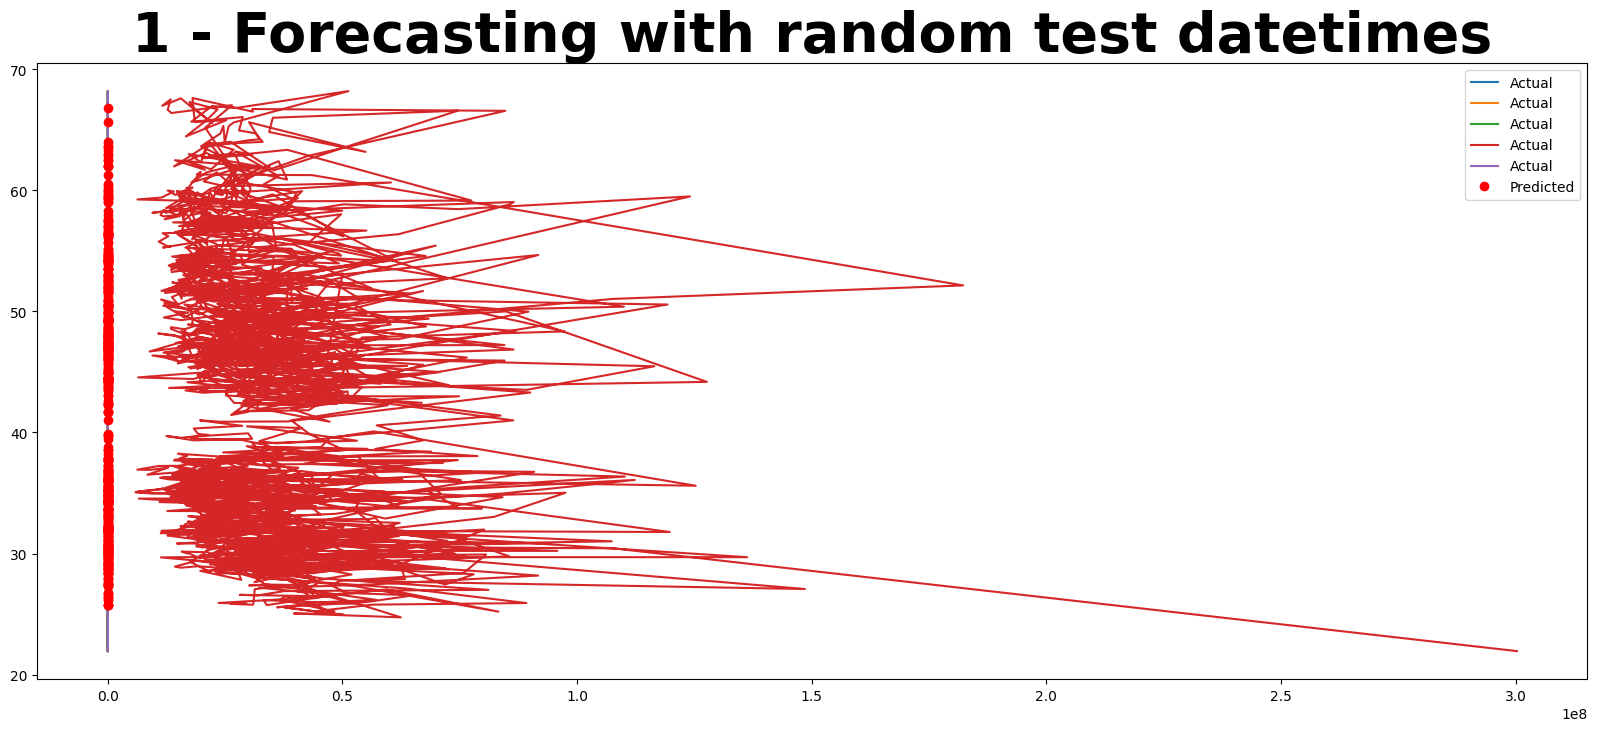

In [11]:
# plot the predicted values on top of the actuals
plt.figure(figsize=(20,8))
plt.plot(X, y, label='Actual')
plt.plot(test_dataframe[['Date']], predictions, 'ro', label='Predicted')
plt.title('1 - Forecasting with random test datetimes', weight='bold', fontsize=40);
plt.legend()

In [12]:
#
# TEST 2
#
# Now, train with chronological data upto 1-Jan-2020 and test with all dates after that cutoff
train_dataframe, test_dataframe=dataframe[dataframe.index < '2022-01-01'], dataframe[dataframe.index >= '2022-01-01']

In [13]:
X_train, y_train = date_transform(train_dataframe)
X_test, y_test = date_transform(test_dataframe)

In [14]:
dtModel = DecisionTreeRegressor()
dtModel.fit (X_train, y_train)
dtModel.score (X_test, y_test)

0.9921091086082763

In [15]:
predictions = dtModel.predict(X_test)

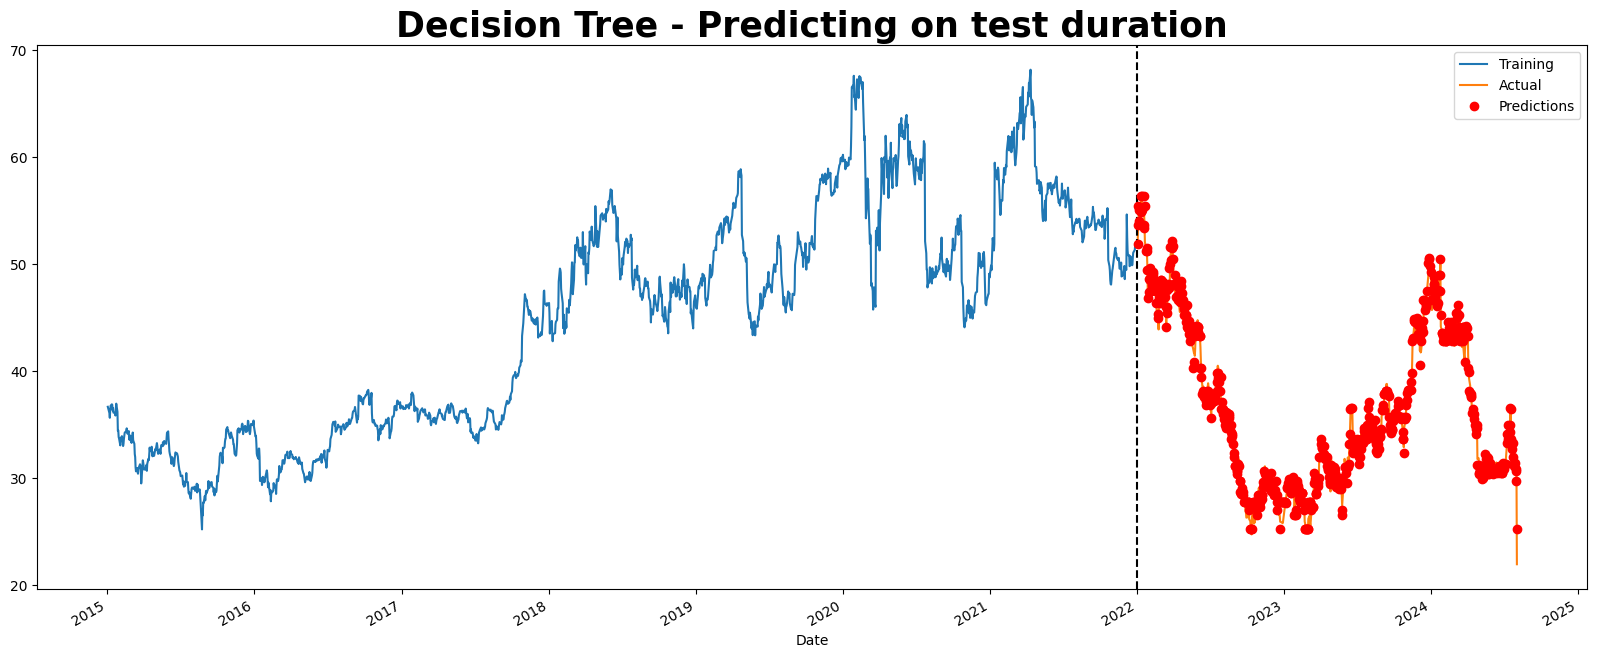

In [16]:
plt.close()
plt.figure(figsize=(20,8))
train_dataframe['Open'].plot(label='Training')
test_dataframe['Open'].plot(label='Actual')
plt.axvline('2022-01-01', color='black', ls='--')
plt.plot(test_dataframe[['Date']], predictions, 'ro', label='Predictions')
plt.title('Decision Tree - Predicting on test duration', weight='bold', fontsize=25)
plt.legend()

In [17]:
#
# Test 3 - Split Date into separate columns and
# train with all available data and predict for future dates
#

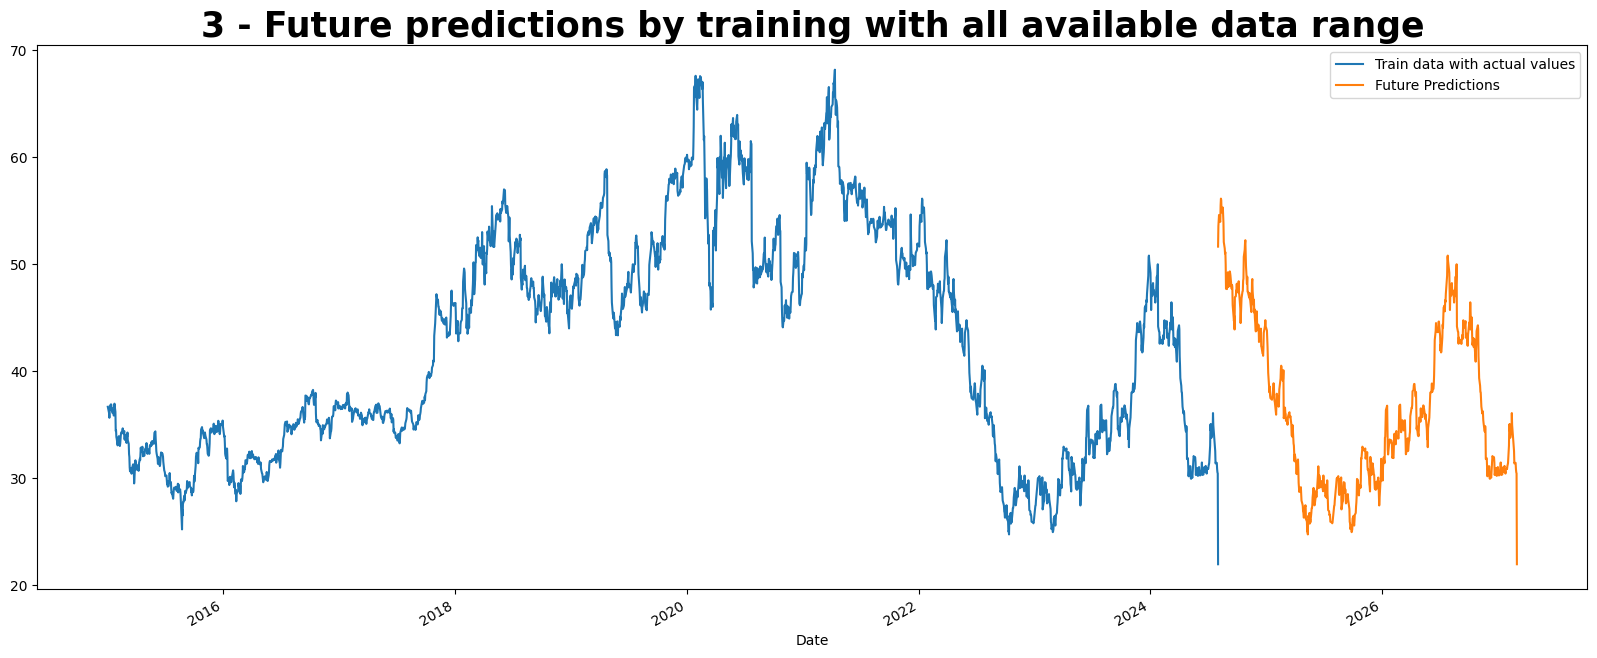

In [18]:
future = 0
future = test_dataframe['Date'].values.copy()
len = future.size
timedelta =future[len-1]-future[0];

for index, datetime in enumerate(future):
    future[index] += timedelta;

future_dataframe = test_dataframe.copy(deep=True);

future_dataframe['Date'] = future.tolist();

future_dataframe['Date'] = pd.to_datetime(future_dataframe['Date'], dayfirst=True)
future_dataframe.sort_index(inplace=True)

X_train, y_train = date_transform(dataframe)
X_test, y_test = date_transform(future_dataframe)

dtModel = DecisionTreeRegressor()
dtModel.fit (X_train, y_train)
predictions = dtModel.predict(X_test)

plt.close()
plt.figure(figsize=(20,8))
dataframe['Open'].plot(label='Train data with actual values');
#test_dataframe['Open'].plot(label='Test data with actual values');
plt.plot(future_dataframe['Date'].values, predictions, label='Future Predictions')
plt.title('3 - Future predictions by training with all available data range', weight='bold', fontsize=25)
plt.legend()